# Train S2F model and analyze sequence features

Here we will demonstrate how to perform a simple analysis of ATAC data with a sequence to function model using some tools from DRG. 

## Download utilized genome

In [6]:
import os
import subprocess
import sys

# Create the directory if it doesn't exist
os.makedirs(os.path.expanduser("~/data/genomes/danRer11"), exist_ok=True)

# Change to the directory
os.chdir(os.path.expanduser("~/data/genomes/danRer11"))

# Download the genome assembly
subprocess.run([
    "wget",
    "ftp://hgdownload.soe.ucsc.edu/goldenPath/danRer11/bigZips/danRer11.fa.gz",
    "-O", "danRer11.fa.gz"
])

# Download the gene annotation
subprocess.run([
    "wget",
    "ftp://ftp.ensembl.org/pub/release-104/gtf/danio_rerio/Danio_rerio.GRCz11.104.gtf.gz",
    "-O", "GRCz11.104.gtf.gz"
])


--2025-04-08 10:55:47--  ftp://hgdownload.soe.ucsc.edu/goldenPath/danRer11/bigZips/danRer11.fa.gz
           => ‘danRer11.fa.gz’
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /goldenPath/danRer11/bigZips ... done.
==> SIZE danRer11.fa.gz ... 543241465
==> PASV ... done.    ==> RETR danRer11.fa.gz ... done.
Length: 543241465 (518M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  0%  158K 56m2s
    50K .......... .......... .......... .......... ..........  0%  317K 41m58s
   100K .......... .......... .......... .......... ..........  0% 11.4M 28m14s
   150K .......... .......... .......... .......... ..........  0% 11.5M 21m21s
   200K .......... .......... .......... .......... ..........  0%  327K 22m29s
   25

CompletedProcess(args=['wget', 'ftp://ftp.ensembl.org/pub/release-104/gtf/danio_rerio/Danio_rerio.GRCz11.104.gtf.gz', '-O', 'GRCz11.104.gtf.gz'], returncode=0)

# Visualize data and normalize

                  anterior.posterior.axis  central.nervous.system  forebrain  \
chr1:5232-5732                   4.612648                5.204557   3.391132   
chr1:5787-6287                   4.721959                5.358137   3.557652   
chr1:10088-10588                 4.806994                5.338711   3.360469   
chr1:10991-11491                 4.879061                5.578282   4.236443   
chr1:11895-12395                 5.052703                5.736003   4.323331   

                  immature.eye  integument  lateral.plate.mesoderm  \
chr1:5232-5732        4.552681    3.668004                4.766655   
chr1:5787-6287        4.688727    3.546239                4.748463   
chr1:10088-10588      4.163852    3.668004                4.955051   
chr1:10991-11491      4.404106    4.145129                4.893466   
chr1:11895-12395      4.790483    4.440677                5.033977   

                  mesenchyme.cell  musculature.system  neural.crest  \
chr1:5232-5732           4.

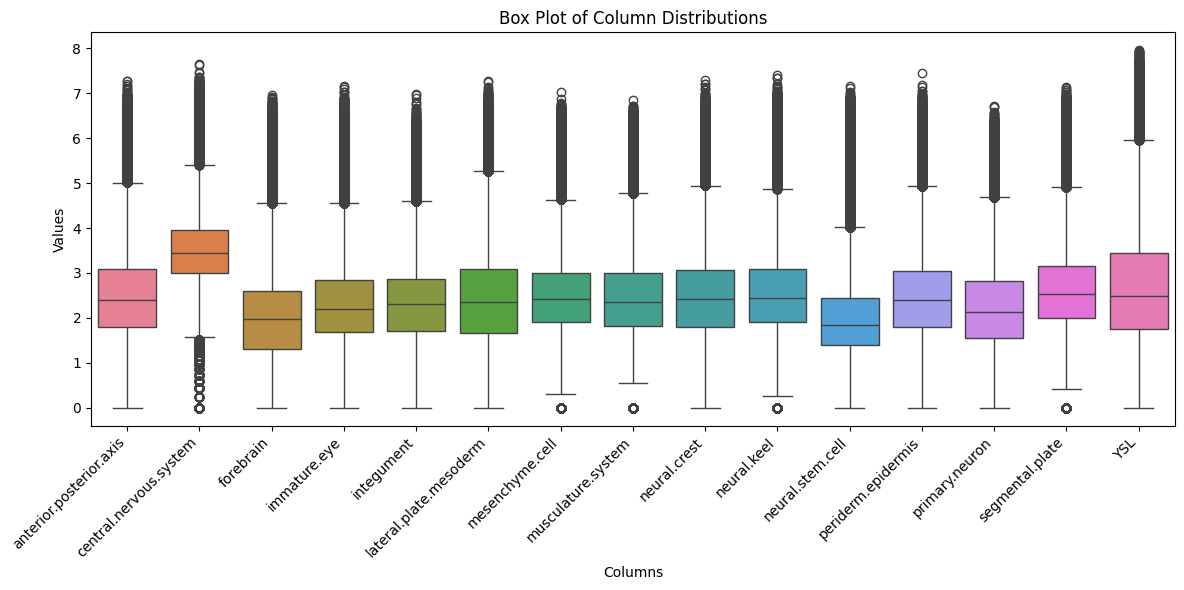

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Define the path to the CSV file
PATH = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.csv')

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(PATH, index_col=0)
print(data.head())
# Plot a box plot for the distributions in each column
plt.figure(figsize=(12, 6))
sns.boxplot(data=data)

# Set the x-tick labels to the column names
plt.xticks(rotation=45, ha='right')
plt.title('Box Plot of Column Distributions')
plt.xlabel('Columns')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()


anterior.posterior.axis    2.395626
central.nervous.system     3.441339
forebrain                  1.984860
immature.eye               2.197871
integument                 2.300787
lateral.plate.mesoderm     2.354598
mesenchyme.cell            2.409666
musculature.system         2.360297
neural.crest               2.415504
neural.keel                2.442039
neural.stem.cell           1.841349
periderm.epidermis         2.405200
primary.neuron             2.141170
segmental.plate            2.531056
YSL                        2.489766
dtype: float64


/home/sasse/miniconda3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sasse/miniconda3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


chr1:5232-5732             0.689872
chr1:5787-6287             0.712622
chr1:10088-10588           0.732119
chr1:10991-11491           0.880135
chr1:11895-12395           0.817345
                             ...   
chr25:37496849-37497349    0.739670
chr25:37498519-37499019    0.783834
chr25:37499249-37499749    0.437743
chr25:37499773-37500273    0.526545
chr25:37501135-37501635    0.402437
Length: 370058, dtype: float64


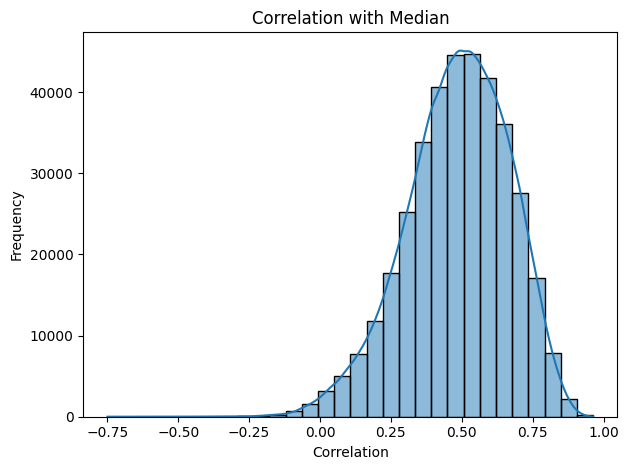

In [ ]:
# plot the correlation of each data point across columns to the median
# Calculate the median
median = data.median(axis=0)
# Calculate the correlation of each data point with the median
correlation = data.corrwith(median, axis=1)
sns.histplot(correlation, bins=30, kde=True)
plt.title('Correlation with Median')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

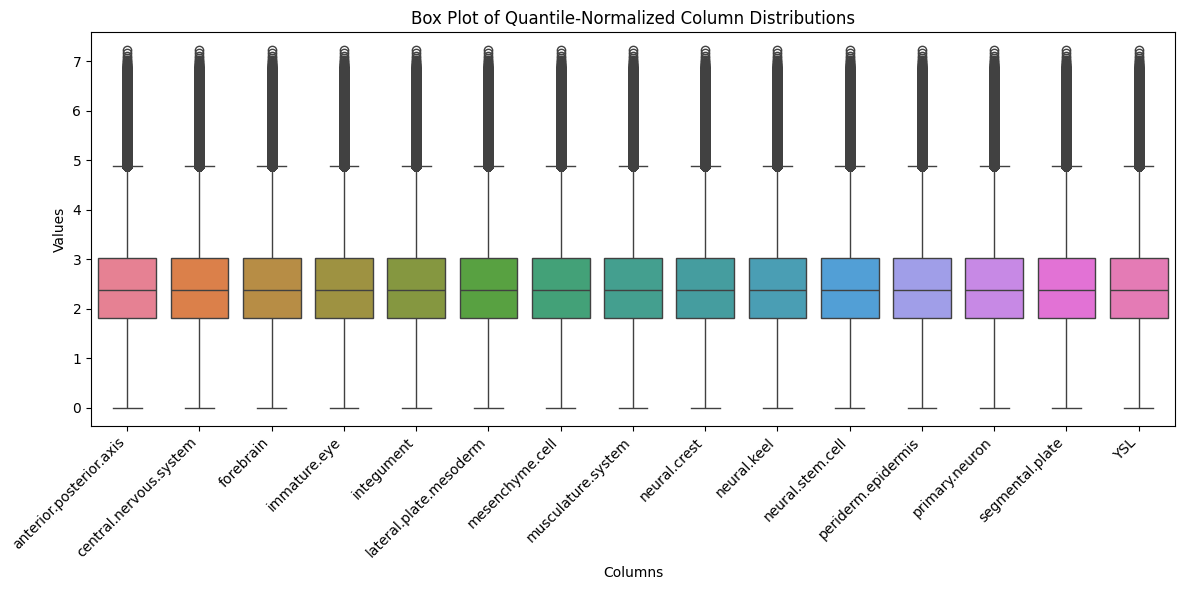

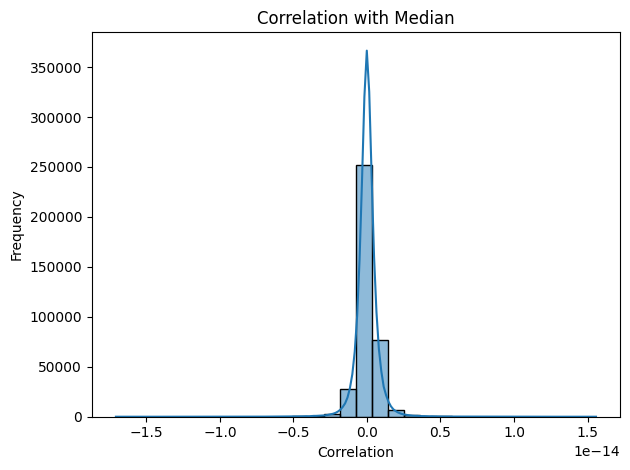

In [12]:
# Perform quantile normalization
def quantile_normalize(df):
    sorted_df = np.sort(df.values, axis=0)
    mean_sorted = np.mean(sorted_df, axis=1)
    ranks = np.argsort(np.argsort(df.values, axis=0), axis=0)
    normalized = mean_sorted[ranks]
    return pd.DataFrame(normalized, columns=df.columns, index=df.index)

normalized_data = quantile_normalize(data)

# Plot a box plot for the quantile-normalized data
plt.figure(figsize=(12, 6))
sns.boxplot(data=normalized_data)

# Set the x-tick labels to the column names
plt.xticks(rotation=45, ha='right')
plt.title('Box Plot of Quantile-Normalized Column Distributions')
plt.xlabel('Columns')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()

# plot the correlation of each data point across columns to the median
# Calculate the median
median = normalized_data.median(axis=0)
# Calculate the correlation of each data point with the median
correlation = normalized_data.corrwith(median, axis=1)
sns.histplot(correlation, bins=30, kde=True)
plt.title('Correlation with Median')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [21]:
# Save the quantile-normalized data to a new CSV file
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.qn.csv')
normalized_data.index.name = '# position'

normalized_data.to_csv(output_path, index=True)
print(f"Quantile-normalized data saved to {output_path}")

Index(['anterior.posterior.axis', 'central.nervous.system', 'forebrain',
       'immature.eye', 'integument', 'lateral.plate.mesoderm',
       'mesenchyme.cell', 'musculature.system', 'neural.crest', 'neural.keel',
       'neural.stem.cell', 'periderm.epidermis', 'primary.neuron',
       'segmental.plate', 'YSL'],
      dtype='object')
Quantile-normalized data saved to /home/sasse/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.qn.csv


In [54]:
import re
indices = data.index.tolist()
print(indices[:10])
# split the indices at : and -
locations = [re.split('[:-]', i) for i in indices]
print(locations[:10])

# save locations in a bed file with chromosome, start, end, name
with open(f'{os.path.splitext(PATH)[0]}.bed', 'w') as f:
    for l, loc in enumerate(locations):
        if len(loc) == 3:
            f.write(f"{loc[0]}\t{loc[1]}\t{loc[2]}\t{indices[l]}\n")
        else:
            print(f"Skipping invalid entry: {loc}")

['chr1:5232-5732', 'chr1:5787-6287', 'chr1:10088-10588', 'chr1:10991-11491', 'chr1:11895-12395', 'chr1:12474-12974', 'chr1:14016-14516', 'chr1:14704-15204', 'chr1:16672-17172', 'chr1:18404-18904']
[['chr1', '5232', '5732'], ['chr1', '5787', '6287'], ['chr1', '10088', '10588'], ['chr1', '10991', '11491'], ['chr1', '11895', '12395'], ['chr1', '12474', '12974'], ['chr1', '14016', '14516'], ['chr1', '14704', '15204'], ['chr1', '16672', '17172'], ['chr1', '18404', '18904']]


## Create one-hot encodings for modeling

In [ ]:
import os
import numpy as np
import drg_tools as drg
from drg_tools import io_utils as utils
from drg_tools import plotlib as drgplt
from drg_tools import sequence_utils as sutils

PATH = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.csv')
# extract sequences from bed file and genome file
bed_file = f'{os.path.splitext(PATH)[0]}.bed' 
genome_file = os.path.expanduser('~/data/genomes/danRer11/danRer11.fa.gz')
seq_len = 500
extend_to = 500
extend = int((seq_len - extend_to) / 2)
# Extract sequences from the bed file and genome file

seqnames, seqs = utils.extract_sequences_from_bed(bed_file, genome_file, extend_before = extend, extend_after = extend)

onehot = []
for s, seq in enumerate(seqs):
    onehot.append(sutils.seq_onehot(seq))

# Convert the list of one-hot encoded sequences to a numpy array
onehot = np.array(onehot)
seqnames = np.array(seqnames)
# Print the shape of the one-hot encoded sequences
print(onehot.shape)
# Save the one-hot encoded sequences to a numpy file
output_path = os.path.splitext(bed_file)[0] + '.oh.npz'
# Save the one-hot encoded sequences and names to a numpy file
# call the arrays seqfeatures and genenames for compatibility with the rest of the code
np.savez(output_path, seqfeatures = onehot, genenames = seqnames)
print(f"One-hot encoded sequences saved to {output_path}")




(370058, 500, 4)
One-hot encoded sequences saved to /home/sasse/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.oh.npz


## Create a test set file with 10 data splits based on separate chromosomes

In [6]:
from drg_tools.data_processing import generatetesttrain

PATH = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.csv')
bed_file = f'{os.path.splitext(PATH)[0]}.bed' 

if os.path.splitext(bed_file)[1] == '.bed': 
    bed = np.genfromtxt(bed_file, dtype = str)

outname = os.path.splitext(bed_file)[0]+'_tset10.txt'
generatetesttrain(bed[:, 3], bed[:,0], outname, kfold = 10)



Best split 2811.4
0 ['chr1' 'chr7'] 145
1 ['chr13' 'chr5'] -485
2 ['chr20' 'chr3'] -4436
3 ['chr16' 'chr6'] -4673
4 ['chr2' 'chr9'] -4459
5 ['chr8' 'chr17' 'chr25'] 3332
6 ['chr23' 'chr14' 'chr22'] 2309
7 ['chr24' 'chr18' 'chr10'] 1678
8 ['chr21' 'chr19' 'chr12'] 3431
9 ['chr15' 'chr4' 'chr11'] 3166


## Train model with script

In [ ]:
import subprocess
import os

PATH = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.csv')
bed_file = f'{os.path.splitext(PATH)[0]}.bed' 

inseq=os.path.splitext(bed_file)[0]+'.oh.npz' # one hot encoded sequences
target=os.path.splitext(bed_file)[0]+'.qn.csv' # Data matrix with data points in rows, and tracks in columns
crossval_file=os.path.splitext(bed_file)[0]+'_tset10.txt' # Can either be number of folds, or a file with # Set N \n, followed by a line with all data point names that are in this set separated by a space. 
fold=0 # fold to use for testing, 0 for all
# Set the parameters for the model
seq_len=500 # length of the sequences

model_parameters = {
'l_kernels' : 19, # kernel size
'kernel_bias' : False,
'reverse_complement' : True, # needs to be assigned with --reverse_complement
'num_kernels' : 300, # Number of kernels in first layer
'pooling_size': 2, # pooling size after first layer
'dilated_convolutions' : 5, # number of dilated conv. blocks
'l_dilkernels' : 7,
'dilations' : [1,2,4,8,16], # dilation rates for each block
'dilpooling_residual' :  1, # number conv blocks to skip in each residual
'dilmax_pooling' : 0, # max pooling size after each conv. block
'transformer_convolutions' : 5, # number of convolutions with max pooling after first layers of residual blocks
# select as l_seq/pooling_size /trmax_pooling**transformer_convolutions = 10
'l_trkernels' : 7,
'trmax_pooling' : 2,
'fclayer_size' : 512, # dimension for fully connected layer
'nfc_layers': 2, # number of fully connected layers after conv. blocks
'conv_batch_norm' : True, # batch normalization after each conv. block
}

training_parameters = {
'epochs' : 100, # training epochs
'patience' : 5, # patience for early stopping
'finetuning' : False, # Fine tuning with reduced lr
'keepmodel' : True, # Keep model parameters after training and computation of performance etc. 
'lr' : 0.000005, # learning rate
'device' : "cuda:0", # device to use for training
'batchsize' : 128, # batch size
'validation_loss': 'Correlationclass',
'optimizer' : 'SGD', # optimizer to use
'optim_params' : 0.9, # momentum
'outclass' : 'Linear', # output class
'shift_sequence' : 5, # shift sequence for data augmentation
'random_shift' : True,
'fc_dropout' : 0.1, # dropout after conv. layers
'warm_up_epochs' : 3 # warm up epochs
}

# Combine individual choices to provide for the model
cnn="+".join(f"{key}={value}" for key, value in model_parameters.items())
training="+".join(f"{key}={value}" for key, value in training_parameters.items())

VARS=cnn+'+'+training
VARS=VARS.replace(' ', '')
print(VARS)

script_path = os.path.expanduser('~/Git/DRG/scripts/train_models/run_cnn_model.py')
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
process = subprocess.Popen(["python", script_path, inseq, target, '--delimter', ',', '--reverse_complement', "--cross_validation", crossval_file, str(fold), "10", "--cnn", VARS, "--save_correlation_perpoint", "--save_correlation_perclass", '--outdir', output_path])

#if process.poll() is None:
    #print("Process is still running")
#else:
    #print("Process has terminated")
# Terminate the subprocess
#process.terminate()  # Gracefully terminate the process


l_kernels=19+kernel_bias=False+reverse_complement=True+num_kernels=300+pooling_size=2+dilated_convolutions=5+l_dilkernels=7+dilations=[1,2,4,8,16]+dilpooling_residuals=1+dilmax_pooling=0+transformer_convolutions=5+l_trkernels=7+trmax_pooling=2+fclayer_size=512+nfc_layers=2+conv_batchnorm=True+epochs=100+patience=5+finetuning=False+keepmodel=True+lr=5e-06+device=cuda:0+batchsize=128+validation_loss=Correlationclass+optimizer=SGD+optim_params=0.9+outclass=Linear+shift_sequence=5+random_shift=True+fc_dropout=0.1+warm_up_epochs=3


Input shapes X (370058, 4, 500)
Output shapes Y (370058, 15)
Train 296046
Test 37006
Val 37006
Device cuda:0
ALL file names /home/sasse/CZS/Projects/ZebraFishDevelopment/Models/psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv10-0_MSEk300l19FfGELUmax2vlCosssft51_dc5i1d1-2-4-8-16s1l7r1_tc5dNoned1s1r1l7ma2nfc2s512fdo0.1tr5e-06SGD0.9bs128-F
In features 4 510
Convolutions 300 510
Pooling 300 255
2nd convolutions 300 255
Convolution after attention 300 8
Before FCL 2400
outclasses 15
convolutions.conv1d.weight 	 torch.Size([300, 4, 19])
convolution_layers.convlayers.Conv0.conv1d.weight 	 torch.Size([300, 300, 7])
convolution_layers.convlayers.Conv1.conv1d.weight 	 torch.Size([300, 300, 7])
convolution_layers.convlayers.Conv2.conv1d.weight 	 torch.Size([300, 300, 7])
convolution_layers.convlayers.Conv3.conv1d.weight 	 torch.Size([300, 300, 7])
convolution_layers.convlayers.Conv4.conv1d.weight 	 torch.Size([300, 300, 7])
trconvolution_layers.convlayers.Conv0.conv1d.weight 	 torch.Size([300, 300, 7])
t

## Look at training curves

/home/sasse/CZS/Projects/ZebraFishDevelopment/Models/psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv10-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1-2-4-8-16s1l7r1_tc5dNoned1s1r1l7ma2nfc2s512fdo0.1tr5.1e-06SGD0.9bs128-F_loss.txt
/home/sasse/CZS/Projects/ZebraFishDevelopment/Models/psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv10-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1-2-4-8-16s1l7r1_tc5dNoned1s1r1l7ma2nfc2s512fdo0.1tr5.1e-06SGD0.9bs128-F_loss.txt


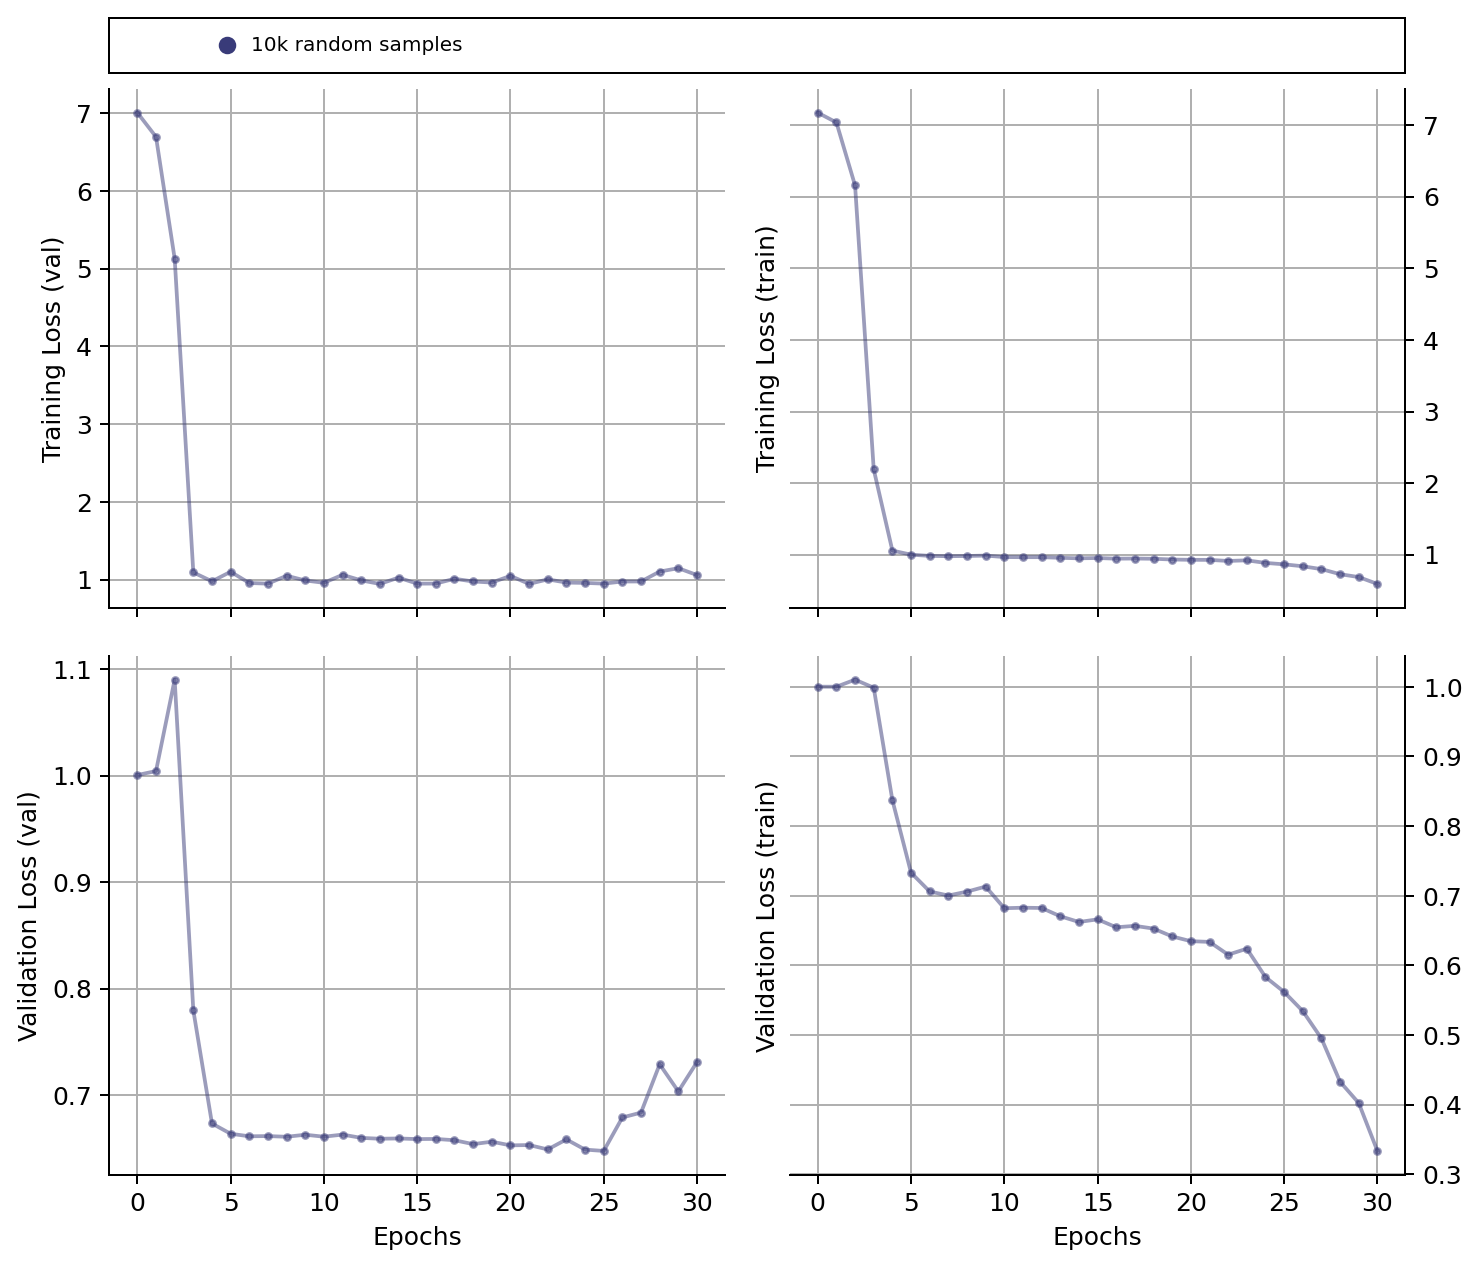

In [ ]:
from drg_tools.plotlib import plot_losses
import os
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv10-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1-2-4-8-16s1l7r1_tc5dNoned1s1r1l7ma2nfc2s512fdo0.1tr5.1e-06SGD0.9bs128-F'
losslog = os.path.join(output_path, model_stem, '_loss.txt')
print(losslog)
# Plot the losses
plot_losses(losslog, '10k random samples', percentages=False, combine_sets=False, logx=False, adjust_axis=False, savefig=None)


## Look at the performance of the trained model

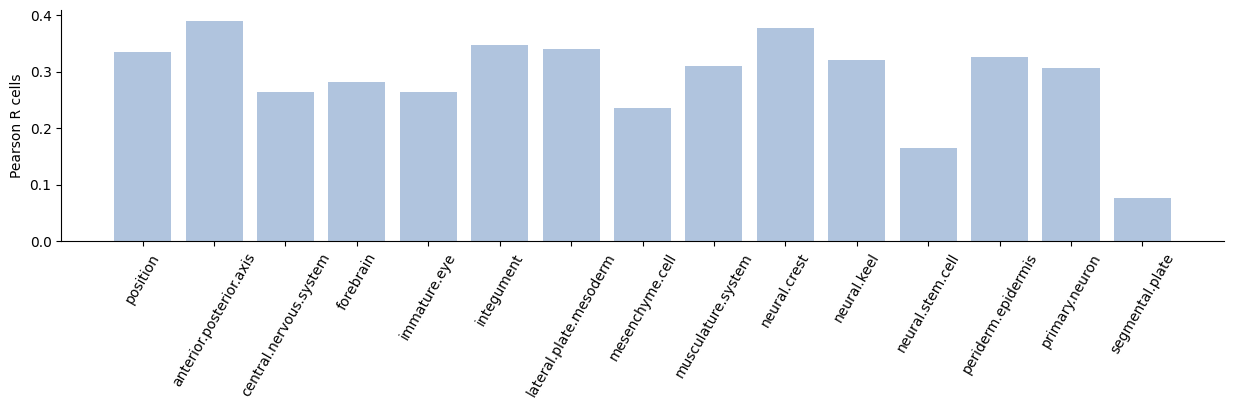

In [3]:
from drg_tools.plotlib import _bar_plot
import os
import numpy as np
import matplotlib.pyplot as plt
# Load the correlation data
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv10-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1-2-4-8-16s1l7r1_tc5dNoned1s1r1l7ma2nfc2s512fdo0.1tr5.1e-06SGD0.9bs128-F'
trackcorr = os.path.join(output_path, model_stem) + '_clss_corr_tcl0.txt'
corrvalues = np.genfromtxt(trackcorr, dtype = str)
#print(corrvalues)
ax = _bar_plot(1.-corrvalues[:,1].astype(float), ylabel = 'Pearson R cells', horizontal = False, xticklabels = corrvalues[:,0], rotation = 60)
plt.show()


yaxis 38.0


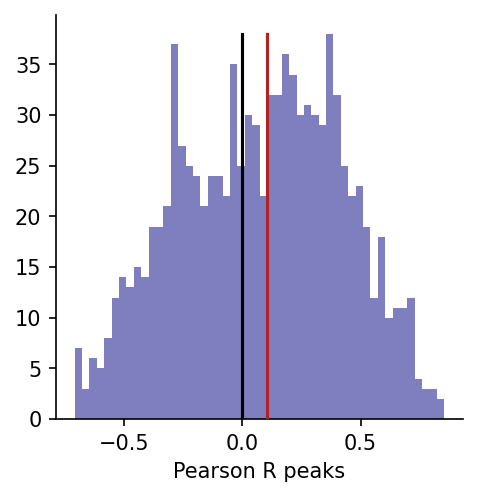

In [6]:
from drg_tools.plotlib import plotHist
import os
import numpy as np
import matplotlib.pyplot as plt

# Load the correlation data
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv10-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1-2-4-8-16s1l7r1_tc5dNoned1s1r1l7ma2nfc2s512fdo0.1tr5.1e-06SGD0.9bs128-F'
peakcorr = os.path.join(output_path, model_stem) + '_pnt_corr_tcl0.txt'
corrvalues = np.genfromtxt(peakcorr, dtype = str)
ax = plotHist(1.-corrvalues[:,1].astype(float), add_median = True, add_yaxis= True, xlabel = 'Pearson R peaks', bins = 50)
plt.show()

## Load model and look at attributions for neural creast cells

cuda:0
training True
seed 101010
verbose True
loss_function MSE
validation_loss Correlationclass
loss_weights 1
val_loss_weights 1
kwargs {'dilpooling_residuals': 1, 'conv_batchnorm': True, 'finetuning': False, 'warm_up_epochs': 3}
keepmodel True
n_features 4
reverse_complement False
complement_pool max
l_seqs 500
n_classes 15
shift_sequence 5
random_shift True
reverse_sign False
smooth_onehot 0
restart False
adjust_lr F
kernel_lr None
num_kernels 300
l_kernels 19
kernel_bias False
kernel_function GELU
nlconv False
nlconv_position_wise False
nlconv_fclayer None
nlconv_explicit False
nlconv_nfc 5
net_function GELU
kernel_thresholding 0
fixed_kernels None
motif_cutoff None
warm_start False
hot_start False
hot_alpha None
max_pooling True
mean_pooling False
weighted_pooling False
pooling_size 2
pooling_steps 2
dilated_convolutions 1
strides 1
dilations [1, 2, 4, 8, 16]
conv_increase 1.0
dilpooling_residual 1
dilpooling_steps 1
dilresidual_entire False
dilresidual_concat False
l_dilkernels 

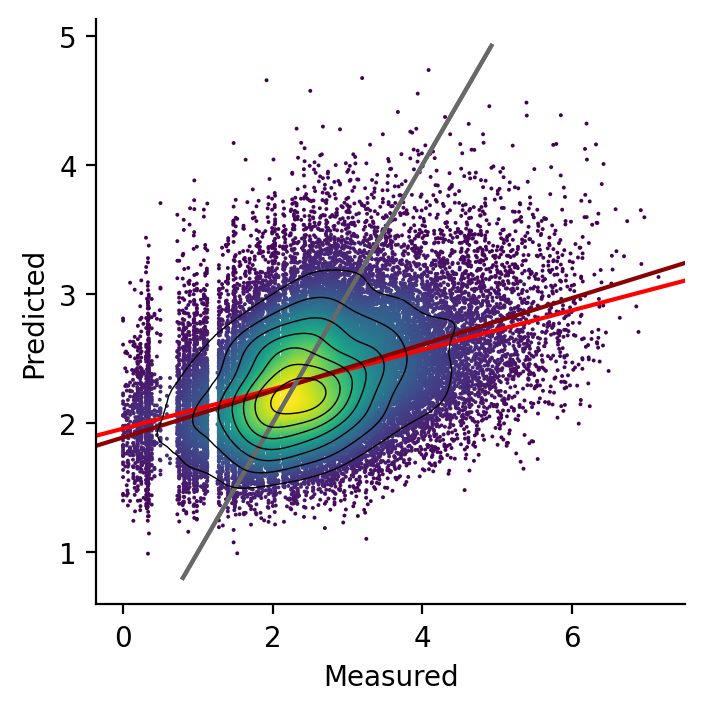

In [2]:
from drg_tools.model_utils import get_device, process_cnn_arguments, load_parameters
from drg_tools.cnn_model import cnn 
from drg_tools.io_utils import readin
from drg_tools.model_training import create_sets, batched_predict
import os

data_stem = 'psd.bulk.zfish_atac.10hpf.lg1x'
data_dir = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/')
data_file = os.path.join(data_dir, data_stem) +'.qn.csv'

output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv10-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1-2-4-8-16s1l7r1_tc5dNoned1s1r1l7ma2nfc2s512fdo0.1tr5.1e-06SGD0.9bs128-F'

# model training saved two files, one with the weights and biases (pth), and one with the arguments that defined the model architecture
model_args = os.path.join(output_path, model_stem) +  '_model_params.dat'
model_pth = os.path.join(output_path, model_stem) + '_parameter.pth'

# Load the model arguments
init_args = process_cnn_arguments(model_args, replace_arguments=None)
device = 'cuda:0' #get_device()
print(device)
for ia in init_args:
    print(ia, init_args[ia]) 

# Create the model
model = cnn(**init_args)

# Load the model parameters
load_parameters(model, model_pth, translate_dict = None, allow_reduction = False, exclude = [], include = False)
# Set the model to evaluation mode
model.eval()
# Set model to device
model.to(device)    

# Load the one-hot encoded sequences and measured data and align data points
oh_file = os.path.join(data_dir, data_stem) + '.oh.npz'
X, Y, inputnames, inputfeatures, header = readin(oh_file, data_file, delimiter=',', return_header=True, assign_region=True, n_features=4, combinex=True)

# Check the shape of the data
print(X.shape)
print(Y.shape)
print(inputnames.shape)
print(header)

# Split the data into training and test sets as before
crossval_file=os.path.join(data_dir, data_stem)+'_tset10.txt' # Can either be number of folds, or a file with # Set N \n, followed by a line with all data point names that are in this set separated by a space. 
trainset, testset, valset = create_sets(len(X), crossval_file, 0, Yclass = None, genenames = inputnames)
print('Train', len(trainset))
print('Test', len(testset))
print('Val', len(valset))

# Make predictions with the model using 
test_predictions = batched_predict(model, X[testset], batchsize=128, device=device, shift_sequence=model.shift_sequence, random_shift=model.random_shift)

# Plot predictions versus measured data in a scatter plot
import matplotlib.pyplot as plt
import numpy as np
from drg_tools.plotlib import scatterPlot
nc_index = np.where(np.array(header) == 'neural.crest')[0][0]

scatterPlot(Y[testset,nc_index], test_predictions[:, nc_index], title = None, xlabel = 'Measured', ylabel = 'Predicted', 
            include_fit = True, include_mainvar = True, diagonal = True, plot_axis = True, 
            boxplot_x = None, boxplot_y = None, contour = True, pos_neg_contour = False, 
            color=None, edgecolor = 'silver', cmap = None, sort_color = 'abshigh', 
            color_density = True, vlim = None, sizes = 2, alpha = None, 
            lw = 0., yticklabels = None, yticks = None, xticklabels = None, 
            xticks = None, grid = False, xlim = None, ylim =None, xscale = None, legend = False, 
            add_text = None, yscale = None, ax = None, dpi = 200)
    



## Selected trusted well-predicted data points